Weather temperature regression using neural network with tensorflow.
In this notebook we trained and compared a few combinations of NN models:
* 2 Models with batchnorms were built, first with RELU activation and
HE initialization, second with TanH and Xavier initialization.
* 2 optimizers were used: ADAM and SGD. Different values of momentums for SGD optimizers were chosen.
* 21 different combinations of layers were tested.
* 3 different Dropout probabilities were used
* 2 criterions were used


In [3]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pylab as plt
import numpy as np
%matplotlib inline

torch.manual_seed(2)


In [4]:
# defined 2 classes, one for tanh activation with xavier init,
# second for RELU activation with HE init

class Net_Xavier(nn.Module):

    # Constructor
    def __init__(self, Layers, p=0.0):
        super(Net_Xavier, self).__init__()
        self.hidden = nn.ModuleList()
        self.batch = nn.ModuleList()
        self.drop = nn.Dropout(p=p)

        for input_size, output_size in zip(Layers, Layers[1:]):
            linear = nn.Linear(input_size, output_size)
            torch.nn.init.xavier_uniform_(linear.weight)
            self.hidden.append(linear)
            batch = nn.BatchNorm1d(output_size)
            self.batch.append(batch)

    # Prediction
    def forward(self, x):
        L = len(self.hidden)
        for (l, linear_transform, batch) in zip(range(L), self.hidden, self.batch):
            if l < L - 1:
                x = self.drop(batch(torch.tanh(linear_transform(x))))
            else:
                x = linear_transform(x)
        return x


In [5]:
class Net_He(nn.Module):

    # Constructor
    def __init__(self, Layers, p=0.0):
        super(Net_He, self).__init__()
        self.hidden = nn.ModuleList()
        self.batch = nn.ModuleList()
        self.drop = nn.Dropout(p=p)

        for input_size, output_size in zip(Layers, Layers[1:]):
            linear = nn.Linear(input_size, output_size)
            torch.nn.init.kaiming_uniform_(linear.weight, nonlinearity='relu')
            self.hidden.append(linear)
            batch = nn.BatchNorm1d(output_size)
            self.batch.append(batch)

    # Prediction
    def forward(self, x):
        L = len(self.hidden)
        for (l, linear_transform, batch) in zip(range(L), self.hidden, self.batch):
            if l < L - 1:
                x = self.drop(batch(F.relu(linear_transform(x))))
            else:
                x = linear_transform(x)
        return x


In [6]:
# training function
def train(model, criterion, verification, X_train, Y_train, X_test, Y_test, optimizer, epochs=100):
    i = 0
    loss_accuracy = {'training_loss': [], 'validation_error': []}

    # n_epochs
    for epoch in range(epochs):
        x = X_train
        y = Y_train

        optimizer.zero_grad()
        z = model(x.cuda())
        loss = criterion(z, y.cuda())
        loss.backward()
        optimizer.step()

        train_error = verification(z, y.cuda())
        loss_accuracy['training_loss'].append(train_error)

        # eval
        model.eval()
        yhat = model(X_test)
        val_error = verification(yhat, Y_test.cuda())
        loss_accuracy['validation_error'].append(val_error)
        model.train()

    # print(yhat)
    # print(Y_test)
    return loss_accuracy


In [7]:
import pickle
import pandas as pd

with open('data_past_features_3_days_future.pkl', 'rb') as fp:
    data = pickle.load(fp)

In [8]:
features_basic = ['LAT', 'LON', 'YEAR', 'MONTH', 'DAY', 'T2M_RANGE', 'T2M', 'RH2M', 'PS', 'WS50M', 'WS10M',
                  'WS50M_RANGE', 'WS10M_RANGE', 'ALLSKY_SFC_SW_DWN', 'DAY_OF_YEAR', 'SEASONAL', 'T2M_diff']
target = ['T2M', 'T2M_future_1', 'T2M_future_2']

# %% criterion

models = [Net_He, Net_Xavier]
criterion = [torch.nn.MSELoss(), torch.nn.L1Loss()]
verification = torch.nn.L1Loss()
learning_rate = 0.01
p_list = [0.0, 0.025, 0.05]
momentum_list = [0.0, 0.45, 0.9]
# models = [Net_He]
# criterion = [torch.nn.MSELoss()]
# verification = torch.nn.L1Loss()
# learning_rate = 0.01
# p_list = [0.0]
# momentum_list = [0.0]


In [9]:
def display_result(training_results, layers, model, criterion, p, momentum, optim):
    plt.figure()
    plt.plot(training_results['training_loss'], label='training loss')
    plt.plot(training_results['validation_error'], label='validation loss')
    plt.grid()
    if optim != 'ADAM':
        plt.title('min valid error: ' + str(min(training_results['validation_error']).data) + '\n' + \
                  'layers: ' + str(layers) + ', model: ' + str(model.__class__) + ', criterion: ' + str(criterion) + '\n' + \
                  'dropout p: ' + str(p) + ', momentum: ' + str(momentum) + ', optim: ' + optim)
    else:
        plt.title('min valid error: ' + str(min(training_results['validation_error']).data) + '\n' + \
              'layers: ' + str(layers) + ', model: ' + str(model.__class__) + ', criterion: ' + str(criterion) + '\n' + \
              'dropout p: ' + str(p) + ', optim: ' + optim)
    plt.legend()
    # plt.draw()
    # plt.show(block=True)
    plt.plot()
    # print('min valid result:', min(training_results['validation_error']))
    # print('layers:', layers)
    # print('model:', model.__class__)
    # print('criterion:', criterion)

def display_info(results):
    print('minimum val error:', results[0])
    print('minimum training loss', results[1])
    print('layers:', results[2])
    print('model:', results[3].__class__)
    print('criterion:', results[4])
    print('Dropout p:', results[5])
    if results[7] != 'ADAM':
        print('momentum:', results[6])
    print('optimizer:', results[7])
    print('model number:', results[8], '\n')

    with open(f'nn_models/model_{results[8]}_training_results.pkl', 'rb') as fp:
        results_plot = pickle.load(fp)
    display_result(*results_plot)


# TEST for models with all avaliable features

In [10]:
X = pd.DataFrame()
Y = pd.DataFrame()
for feature in data.columns:
    if not feature in features_basic + ['T2M_future_1', 'T2M_future_2']:  # get useful data
        X[feature] = data[feature]

for feature in target:
    Y[feature] = data[feature]

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=12)

X_train = torch.tensor(X_train.values.astype(np.float32))
X_test = torch.tensor(X_test.values.astype(np.float32))
Y_train = torch.tensor(Y_train.values.astype(np.float32))
Y_test = torch.tensor(Y_test.values.astype(np.float32))

X_train = X_train.cuda()
X_test = X_test.cuda()
Y_train = Y_train.cuda()
Y_test = Y_test.cuda()

print(X_train.size())
print(Y_train.size())

torch.Size([1456, 33])
torch.Size([1456, 3])


In [11]:
input_dim = X_train.size()[1]  # for this data its 33
output_dim = Y_train.size()[1]  # for this data its 3
layers = [[input_dim, 33, 33, output_dim],
          [input_dim, 66, 66, output_dim],
          [input_dim, 132, 132, output_dim],
          [input_dim, 33, 33, 33, output_dim],
          [input_dim, 66, 66, 66, output_dim],
          [input_dim, 66, 33, 33, output_dim],
          [input_dim, 66, 33, 66, output_dim],
          [input_dim, 66, 66, 33, output_dim],
          [input_dim, 33, 66, 33, output_dim],
          [input_dim, 132, 132, 132, output_dim],
          [input_dim, 33, 33, 33, 33, output_dim],
          [input_dim, 66, 66, 66, 66, output_dim],
          [input_dim, 33, 66, 33, 66, output_dim],
          [input_dim, 132, 66, 33, 33, output_dim],
          [input_dim, 132, 132, 66, 33, output_dim],
          [input_dim, 132, 132, 132, 132, output_dim],
          [input_dim, 33, 33, 33, 33, 33, output_dim],
          [input_dim, 66, 66, 66, 66, 66, output_dim],
          [input_dim, 66, 66, 33, 33, 33, output_dim],
          [input_dim, 132, 66, 66, 33, 33, output_dim],
          [input_dim, 132, 132, 132, 132, 132, output_dim],
          ]

In [ ]:
import pickle

# SGD optimizer
print('SGD')
optim = 'SGD'
iteration = 0
results = []
for criterion_pick in criterion:
    for layer in layers:
        for model_def in models:
            for p in p_list:
                for momentum in momentum_list:
                    model = model_def(layer, p)
                    model.cuda()
                    # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, momentum=momentum)
                    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
                    training_results = train(model, criterion_pick, verification, X_train, Y_train, X_test, Y_test,
                                             optimizer, epochs=400)
                    # display_result(training_results, layer, model, criterion_pick)
                    # results.append((training_results, layer, model, criterion_pick, p, momentum))
                    iteration += 1

                    torch.save(model.state_dict(), f'nn_models/model_{iteration}.pt')
                    with open(f'nn_models/model_{iteration}_training_results.pkl', 'wb') as fp:
                        pickle.dump((training_results, layer, model, criterion_pick, p, momentum, optim), fp)

                    results.append((min(training_results['validation_error']), min(training_results['training_loss']), layer, model, criterion_pick, p, momentum, optim, iteration))

                    print(iteration)



SGD
1
2
3
4
5
6


In [ ]:
print('ADAM')
optim = 'ADAM'
# ADAM optimizer
for criterion_pick in criterion:
    for layer in layers:
        for model_def in models:
            for p in p_list:
                model = model_def(layer, p)
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
                # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
                training_results = train(model, criterion_pick, verification, X_train, Y_train, X_test, Y_test,
                                         optimizer, epochs=400)
                # display_result(training_results, layer, model, criterion_pick)
                # results.append((training_results, layer, model, criterion_pick, p, 0))
                iteration += 1

                torch.save(model.state_dict(), f'nn_models/model_{iteration}.pt')
                with open(f'nn_models/model_{iteration}_training_results.pkl', 'wb') as fp:
                    pickle.dump((training_results, layer, model, criterion_pick, p, momentum, optim), fp)

                results.append((
                               min(training_results['validation_error']), min(training_results['training_loss']), layer,
                               model, criterion_pick, p, momentum, optim, iteration))

                print(iteration)

In [1]:
results.sort(key=lambda x: x[0])

# %% save results

with open('simple_NN_results1.pkl', 'wb') as fp:
    pickle.dump(results, fp)

NameError: name 'results' is not defined

In [12]:
import pickle
with open('simple_NN_results.pkl', 'rb') as fp:
    results = pickle.load(fp)

minimum val error: tensor(2.0413, requires_grad=True)
minimum training loss tensor(1.9159, requires_grad=True)
layers: [33, 33, 33, 3]
model: <class '__main__.Net_He'>
criterion: L1Loss()
Dropout p: 0.025
optimizer: ADAM
model number: 884 

minimum val error: tensor(2.0564, requires_grad=True)
minimum training loss tensor(1.9510, requires_grad=True)
layers: [33, 33, 66, 33, 3]
model: <class '__main__.Net_He'>
criterion: MSELoss()
Dropout p: 0.0
momentum: 0.9
optimizer: SGD
model number: 147 

minimum val error: tensor(2.0569, requires_grad=True)
minimum training loss tensor(2.1425, requires_grad=True)
layers: [33, 33, 33, 3]
model: <class '__main__.Net_He'>
criterion: MSELoss()
Dropout p: 0.05
optimizer: ADAM
model number: 759 

minimum val error: tensor(2.0662, requires_grad=True)
minimum training loss tensor(1.6630, requires_grad=True)
layers: [33, 66, 66, 3]
model: <class '__main__.Net_He'>
criterion: MSELoss()
Dropout p: 0.0
optimizer: ADAM
model number: 763 

minimum val error: te

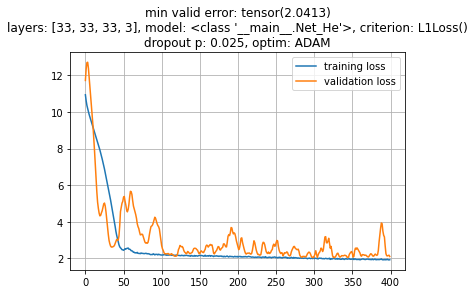

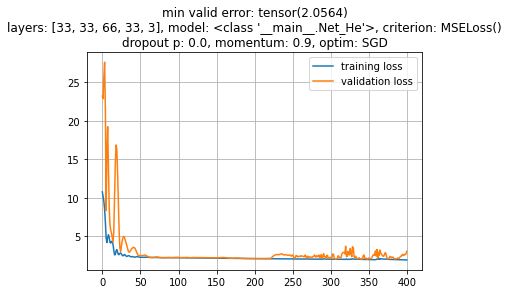

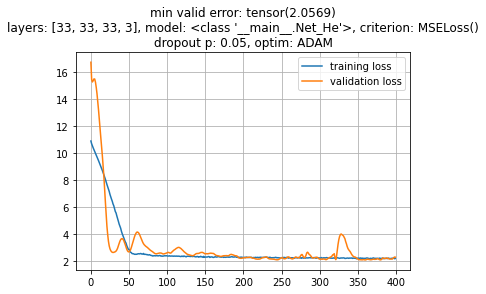

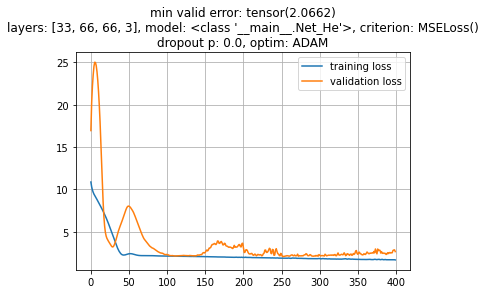

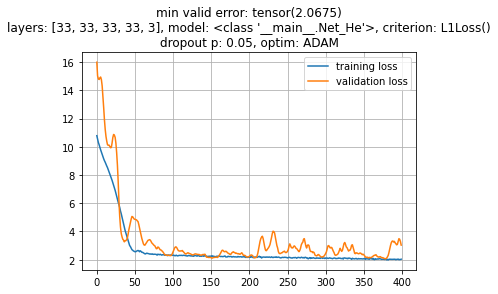

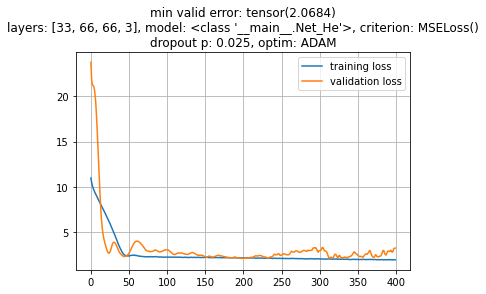

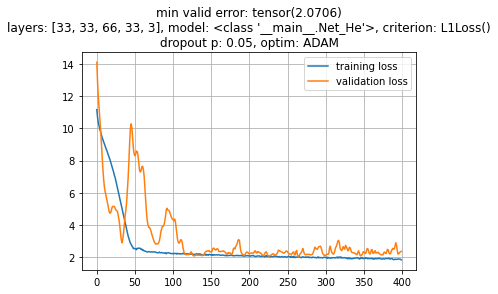

In [13]:
#display 7 first best results
for i in range(7):
    display_info(results[i])
    # note adam has no random

From the results we can note a few conclusions:
* with MSE loss the validaton error is much less leaping. Oscilations with each epoch with L1 are greater which can indicate a little randomnes in results.
* the results are really simmilar with value, from this we can tell that there is not much more space to optimazie the weights.
From this data we cannot get more information, although 1 point for future weather prediction is not enough and the Seasonality in weather is doing the work.
* optimalizer "ADAM" without use of dropout (even with Batchnorm) is overfitting the model with higher epochs (top 4 result)
* The models gives best results often before last epoch, we shall conroll the validation error and save model in best possible position.
* RELU gave much better results then TANH activation